# Beta

**2.4. Procedure**

This study includes ***four*** blocks of online BCI experiments with a cued-spelling task. The experiments were as follows. Each block consisted of ***40 trials***, and there was one trial for each stimulus target in a randomized order. Trials began with a 0.5 s cue (a red square covering the target) for gaze shift, which was followed by flickering on all the targets, and ended with a rest time of 0.5 s.

In [11]:
# imports

from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
import numpy as np
import mne
import matplotlib.pyplot as plt

### Load

In [12]:
# pré-carregamento
data = loadmat(f"../datasets/beta/S9.mat")['data'][0][0]

# 40 targets (40 frequencias pra olhar)
# 64 eletrodos 
# 750 pontos
# 4 trials (4 tentativas do protocolo)
# -> 4, 64, 40, 750
# -> diminuir os 64 para apenas os eletrodos uteis (ocipital)
eeg_data = data[0]
print(eeg_data.shape)

# data structure
print('\nInformações dos dados:')
for field in ['sub', 'age', 'gender', 'chan', 'freqs', 'phases', 'bci_quotient', 'wide_snr', 'narrow_snr','srate']:
  if field != 'chan':
    print(f'=> {field} {data[1][field][0][0].flatten().shape} : {data[1][field][0][0].flatten()}')
  else:
    channels = [data[1][field][0][0][index][3][0] for index in range(64)]
    print(f'=> {field} {len(channels)} : {channels}')
    #selected_ch = [idx for idx, c in enumerate(channels) if c in ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']]
    #print(selected_ch)

(64, 750, 4, 40)

Informações dos dados:
=> sub (1,) : ['S9']
=> age (1,) : [21.33333333]
=> gender (1,) : ['female']
=> chan 64 : ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']
=> freqs (40,) : [ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4]
=> phases (40,) : [4.71238898 0.         1.57079633 3.14159265 4.71238898 0.
 1.57079633 3.14159265 4.71238898 0.         1.57079633 3.14159265
 4.71238898 0.         1.57079633 3.14159265 4.71238898 0.
 1.57079633 3.14159265 4.7123

#### Load Data

In [13]:
# extração direta dos dados
print("Divisão dos dados:")
# opções: ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2'] -> [47, 53, 54, 55, 56, 57, 60, 61, 62]
# eeg = eeg[[], :, :, :] # (64, 750, 4, 40) -> (x, 750, 4, 40)

eeg = eeg_data.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2] * eeg_data.shape[3])
labels = np.array(list(data[1]['freqs'][0][0].flatten()) * 4)
print(eeg.shape, labels.shape)

Divisão dos dados:


(64, 750, 160) (160,)


#### Create MNE

In [14]:
# criação de um objeto "info"
n_channels = 64
sfreq = data[1]['srate'][0][0][0][0]
ch_names = [data[1]['chan'][0][0][index][3][0] for index in range(64)]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

In [15]:
# data : array, shape (n_epochs, n_channels, n_times)
# (64, 750, 160) -> (160, 64, 750)
data_correct = eeg.swapaxes(0, 2)
data_correct = data_correct.swapaxes(1, 2)
print(data_correct.shape)

# adicionando label como "épocas" do sinal
# labels = np.load("../datasets/avi/single/labels.npy")[0]
# # print(labels, labels.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(len(labels), dtype=int),
    le.fit_transform(labels))
)
# print(events)

event_dict = {'8.6': 3, '8.8': 4, '9.0': 5, '9.2': 6, '9.4': 7, '9.6': 8, '9.8': 9, '10.0': 10, '10.2': 11, '10.4': 12, '10.6': 13, '10.8': 14, '11.0': 15, '11.2': 16, '11.4': 17, '11.6': 18, '11.8': 19, '12.0': 20, '12.2': 21, '12.4': 22, '12.6': 23, '12.8': 24, '13.0': 25, '13.2': 26, '13.4': 27, '13.6': 28, '13.8': 29, '14.0': 30, '14.2': 31, '14.4': 32, '14.6': 33, '14.8': 34, '15.0': 35, '15.2': 36, '15.4': 37, '15.6': 38, '15.8': 39, '8.0': 0, '8.2': 1, '8.4': 2}

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
# print(mne_data)

(160, 64, 750)
Not setting metadata
160 matching events found


No baseline correction applied
0 projection items activated


#### Visualização

PSD do evento com label 9.8


/tmp/ipykernel_53602/1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


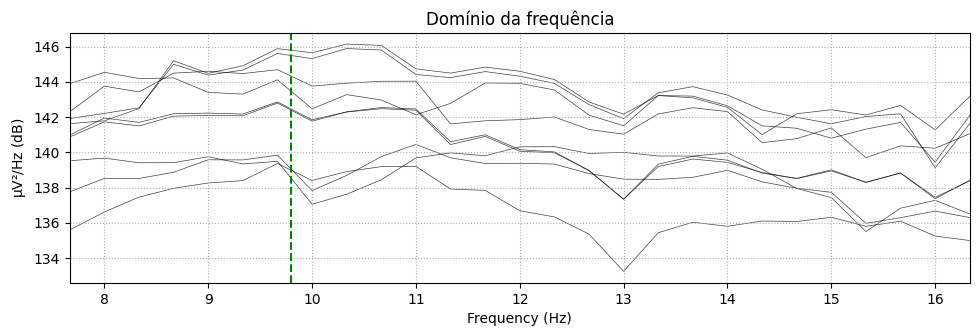

PSD do evento com label 10.6


/tmp/ipykernel_53602/1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


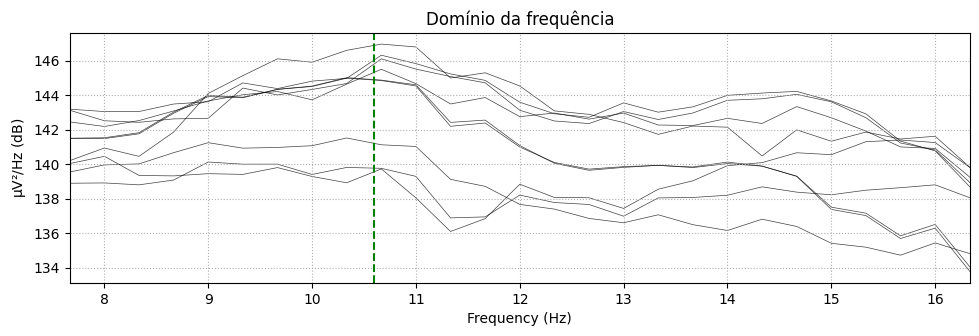

PSD do evento com label 12.600000000000001


/tmp/ipykernel_53602/1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


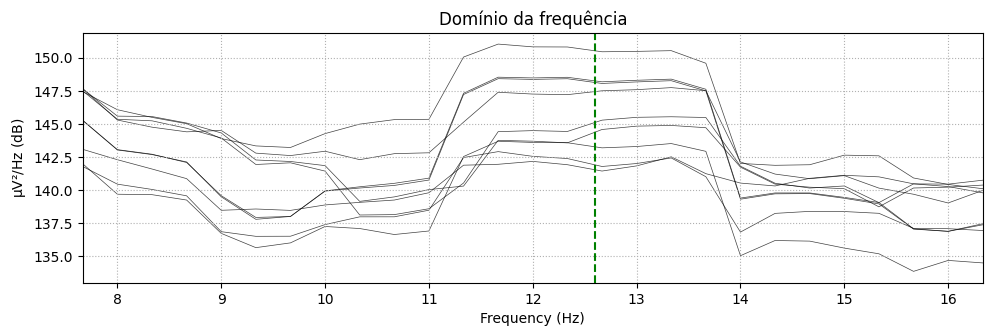

PSD do evento com label 15.600000000000001


/tmp/ipykernel_53602/1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


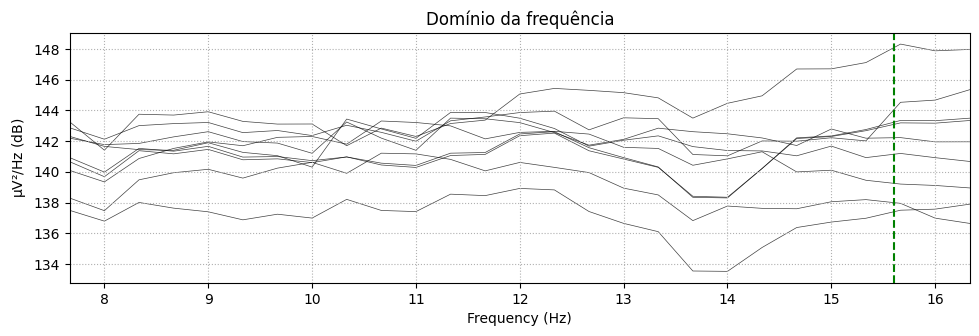

PSD do evento com label 12.600000000000001


/tmp/ipykernel_53602/1450344703.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot(show=False)


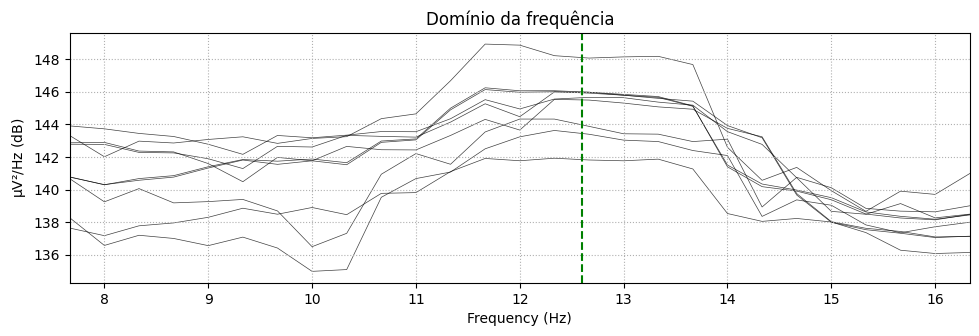

In [16]:
# import warnings
# warnings.filterwarnings('ignore')

mne_data_plot = mne_data
mne_data_plot = mne_data_plot.drop_channels([name for name in ch_names if name not in ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']]) #['O1', 'OZ', 'O2']]) #

for i in [6, 10, 20, 35, 100]: #range(len(mne_data)):
    print('PSD do evento com label', labels[i])
    view = mne_data_plot[i].compute_psd(method='multitaper', fmin=7.5, fmax=16.5, verbose=False)
    view.plot(show=False)
    # print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data_plot[i].event_id)[0]), linestyle='--', color='green')
    plt.show()
# list(mne_data[0].event_id)

#### Classificador

##### Classificador por Frequência Mais Alta

In [17]:
threshold = 0.5
freqs = data[1]['freqs'][0][0].flatten()

y_pred = []

#para todas as instancias
for i in range(len(mne_data)):
    #psd
    item = mne_data[i].compute_psd(method='multitaper', fmin=7.5, fmax=16.5, verbose=False)
    
    #pegar media de cada faixa de frequencia
    classes = []
    for freq in freqs:        
        classes.append( item.get_data(fmin=freq-threshold, fmax=freq+threshold).mean() )
    
    #verificar qual é a maior faixa de freq
    y_pred.append( freqs[np.argmax(classes)] )
    
#calcular acuracia
acuracia = sum(y_pred == labels) / len(labels)
print('Acurácia:',acuracia)

Acurácia: 0.0875


In [18]:
# Prova Real
accy = 0
for i in range(len(labels)):
    print(labels[i], y_pred[i])
    
    if labels[i] == y_pred[i]:
        accy += 1/len(labels)

print(accy)

8.6 8.0
8.799999999999999 12.600000000000001
9.0 9.6
9.2 8.6
9.4 8.6
9.6 8.6
9.8 10.0
10.0 9.6
10.2 10.2
10.4 9.6
10.6 10.6
10.8 10.0
11.0 10.0
11.2 11.6
11.4 11.6
11.6 11.2
11.8 12.2
12.0 11.6
12.2 11.6
12.4 11.6
12.600000000000001 12.0
12.8 13.200000000000001
13.0 12.2
13.200000000000001 13.200000000000001
13.4 14.0
13.600000000000001 14.0
13.8 13.0
14.0 13.200000000000001
14.200000000000001 13.600000000000001
14.4 9.6
14.600000000000001 14.0
14.8 15.200000000000001
15.0 15.600000000000001
15.200000000000001 14.600000000000001
15.4 14.600000000000001
15.600000000000001 15.600000000000001
15.8 15.600000000000001
8.0 15.200000000000001
8.2 15.600000000000001
8.4 8.0
8.6 12.600000000000001
8.799999999999999 11.2
9.0 8.6
9.2 10.0
9.4 8.0
9.6 8.6
9.8 13.200000000000001
10.0 11.6
10.2 10.2
10.4 11.0
10.6 10.0
10.8 10.2
11.0 10.2
11.2 10.6
11.4 11.0
11.6 11.6
11.8 12.2
12.0 12.2
12.2 12.2
12.4 13.0
12.600000000000001 11.6
12.8 12.0
13.0 13.0
13.200000000000001 12.2
13.4 13.200000000000001
1